In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.mlab as mlab

import types as types

import sys as sys
import os as os
sys.path.append('scripts27/')
sys.path.append('scripts27/gauss_mix')

import pyglet as pgl
import numpy as np

from main import Main
import gmix_model as gmix
import gmix_sample_mixture as smpl
import graph_NPZ as graph_highD

Loading chipmunk for Darwin (64bit) [/Users/azane/GitRepo/spider/venv/lib/python2.7/site-packages/pymunk/libchipmunk.dylib]


In [2]:
main = Main()
pgl.app.run()

In [3]:
s_x, s_t = gmix.get_xt_from_npz('data/spi_data.npz', True)

rand_x = np.random.random_sample(size=(1000, main.space.expHQ._xDim))
rand_x *= np.sum((main.space.expHQ._xRange*np.array([[[-1,1]]])), axis=2)
rand_x += np.expand_dims(main.space.expHQ._xRange[:,0],0)

_, pv_v, pv_c, pv_t, pv_s, pv_tests = main.space.expHQ.graph_space(s_x)
pv_v = np.expand_dims(pv_v, 1)

_, rand_pv_v, rand_pv_c, _, rand_pv_s, rand_pv_tests = main.space.expHQ.graph_space(rand_x)
rand_pv_v = np.expand_dims(rand_pv_v, 1)

main.space.expModel.build_graph()
#m, v, u = main.space.expModel.get_xmvu()  # this retrieves from a session that isn't updated!
m, v, u = pv_tests[4], pv_tests[5], pv_tests[6]

rand_m, rand_v, rand_u = rand_pv_tests[4], rand_pv_tests[5], rand_pv_tests[6]

x, y = smpl.mixture_expectation(s_x, m, v, u) #set to gmm expectation
_, rand_y = smpl.mixture_expectation(rand_x, rand_m, rand_v, rand_u) #set to gmm expectation
x, y_smpl = smpl.sample_mixture(s_x, m, v, u) #set to gmm sample

In [4]:
c = pv_tests[7]
t = pv_tests[8]
s = pv_tests[9]

print c.shape
print t.shape
print s.shape

c = np.mean(c, 1)
t = np.squeeze(t)
s = np.mean(s, 1)

print c.shape
print t.shape
print s.shape

print (c+t+s).shape

(35000, 1)
(35000, 1)
(35000, 1)
(35000,)
(35000,)
(35000,)
(35000,)


In [5]:
#print pv_tests[10]

(1000, 4)
(1000, 1)


<IPython.core.display.Javascript object>


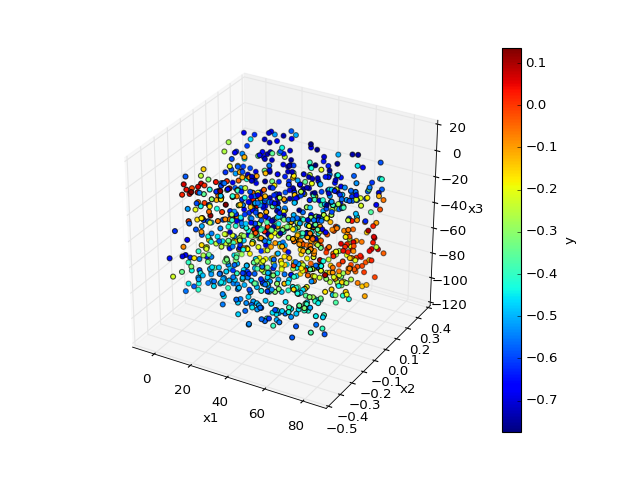

(<matplotlib.figure.Figure at 0x116c50950>,
  <matplotlib.axes._subplots.Axes3DSubplot at 0x113e8b310>])

In [6]:
xCols = [1,2,-1]
yLow = None#-0.05
yHigh = None#0.05
numPoints = 600

#point value
#fig, _ = graph_highD.graph3x1y(s_x, v, xCols=xCols,
#                      sbpltLoc=221, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, c, xCols=xCols, fig=fig,
#                      sbpltLoc=222, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, t, xCols=xCols, fig=fig,
#                      sbpltLoc=223, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, s, xCols=xCols, fig=fig,
#                      sbpltLoc=224, numPoints=numPoints)

#sensor sample
#graph_highD.graph3x1y(s_x, y_smpl, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)
#sensor expecation

print rand_x.shape
print rand_y.shape

#graph_highD.graph3x1y(s_x, y, xCols=xCols,
#                      yLow=yLow, yHigh=yHigh, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

graph_highD.graph3x1y(rand_x, rand_y, xCols=xCols,
                      yLow=yLow, yHigh=yHigh, fig=None,
                      sbpltLoc=111, numPoints=numPoints*2)

#actual sensor
#graph_highD.graph3x1y(s_x, s_t, xCols=xCols,
#                      yLow=yLow, yHigh=yHigh, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

In [7]:
explorerSeries = np.array(main.space.expHQ._explorerSeries)
explorerGradients = np.array(main.space.expHQ._explorerGrads)
explorerVals = np.array(main.space.expHQ._explorerVals)
explorerBest = np.array(main.space.expHQ._explorerBest)

<IPython.core.display.Javascript object>


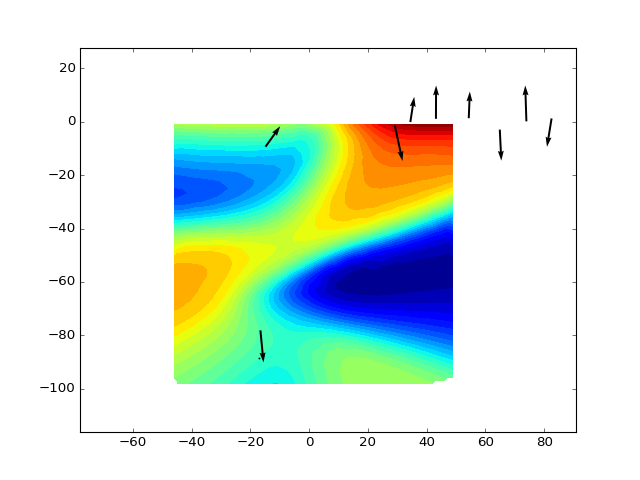

99%

In [8]:
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    #stolen from http://stackoverflow.com/questions/18764814/make-contour-of-scatter
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    Z = mlab.griddata(x, y, z, xi, yi, interp='linear')
    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

#ea is exploration animation
ea_numSkip = 1
ea_viewSection = (.6, .9)
ea_start = int(ea_viewSection[0]*explorerSeries.shape[0])
ea_end = int(ea_viewSection[1]*explorerSeries.shape[0])


ea_mapResolution = 2000 # m
ea_CFindices = np.array([0,-1])  # needs to be 2d for this to work.

ea_fig = plt.figure()

ea_artists = []

ea_EFmask = np.ones(explorerSeries[0,0,:].shape, dtype=bool)  # .shape == (xDim,)
ea_EFmask[ea_CFindices] = 0
ea_full = np.zeros(((ea_mapResolution,) + ea_EFmask.shape), dtype=float)  # .shape == (m, xDim)

ea_conRands = np.random.random_sample(size=(ea_mapResolution, ea_CFindices.size))  #.shape == (m, numCF)
ea_rangeSize = main.space.expHQ._xRange[ea_CFindices]*np.array([[-1,1]])  #.shape == (numCF, 2)
ea_conRands *= np.expand_dims(np.sum(ea_rangeSize, axis=1), 0)  # (m, numCF) * (1, numCF)
ea_conRands += np.expand_dims(main.space.expHQ._xRange[ea_CFindices,0], 0)  # (m, numCF) * (1, numCF)
assert ea_conRands.shape == (ea_mapResolution, ea_CFindices.size)

#For monkey fix below
def ea_setvisible(self,vis):
        for c in self.collections: c.set_visible(vis)
def ea_setanimated(self,anim):
        for c in self.collections: c.set_animated(anim)
####

#TEMP get half explorers for two kinds. dkwig90101kdnfko
#ea_numE = explorerSeries.shape[1]
#ea_half = int(ea_numE/2)
#/TEMP

ea_testHold = None

for i in range(ea_start,ea_end,ea_numSkip):
    ea_completion = ((float(i)/float(explorerSeries.shape[0]))-ea_viewSection[0])/(ea_viewSection[1]-ea_viewSection[0])
    ea_completion = int(100*ea_completion)
    sys.stdout.write("\r%d%%" % ea_completion)
    sys.stdout.flush()
    
    #set the values for all the explorers
    ea_full[:,ea_EFmask] = explorerSeries[i,0,ea_EFmask]  # set environmentals  (m, xDim)[:,numEF] = (numEF,)
    ea_full[:,ea_CFindices] = ea_conRands  # set controls  (m, xDim)[:,numCF] = (m, numCF)
    
    _, ea_pv, ea_pc, ea_pt, ea_ps, _ = main.space.expHQ.graph_space(ea_full)
    
    
    X, Y, Z = grid(np.copy(ea_full[:,ea_CFindices[0]]), np.copy(ea_full[:,ea_CFindices[1]]), np.squeeze(ea_pv))
    
    #create artists
    ea_contour = plt.contourf(X, Y, Z, 30)
    ea_quiver = plt.quiver(explorerSeries[i,:,ea_CFindices[0]], explorerSeries[i,:,ea_CFindices[1]],
                       explorerGradients[(i-1),:,ea_CFindices[0]], explorerGradients[(i-1),:,ea_CFindices[1]],
                          pivot='tail', width=0.004)
    #TEMP dkwig90101kdnfko
    #ea_quiver = plt.quiver(explorerSeries[i,:ea_half,ea_CFindices[0]], explorerSeries[i,:ea_half,ea_CFindices[1]],
    #           explorerGradients[(i-1),:ea_half,ea_CFindices[0]], explorerGradients[(i-1),:ea_half,ea_CFindices[1]],
    #           pivot='tail', width=0.004)
    #ea_scatter = plt.scatter(explorerSeries[i,ea_half:,ea_CFindices[0]], explorerSeries[i,ea_half:,ea_CFindices[1]],
    #                        marker='*')
    #/TEMP
    
    
    ###Monkey Fix from
    #http://matplotlib.1069221.n5.nabble.com/Matplotlib-1-1-0-animation-vs-contour-plots-td18703.html
    ea_contour.set_visible = types.MethodType(ea_setvisible,ea_contour,None)
    #ea_contour.axes = plt.gca()
    ###End monkey fix
    ###Monkey Fix 2
    #adapted from monkey fix 1
    ea_contour.set_animated = types.MethodType(ea_setanimated,ea_contour,None)
    ea_contour.axes = plt.gca()
    ###
    
    ea_artists.append((ea_contour,ea_quiver))

ea_ani = animation.ArtistAnimation(ea_fig, ea_artists, interval=100, repeat_delay=2000, blit=True)
#ea_ani.save('data/ea_test.mp4', metadata={'artist':'Andy'})

<IPython.core.display.Javascript object>


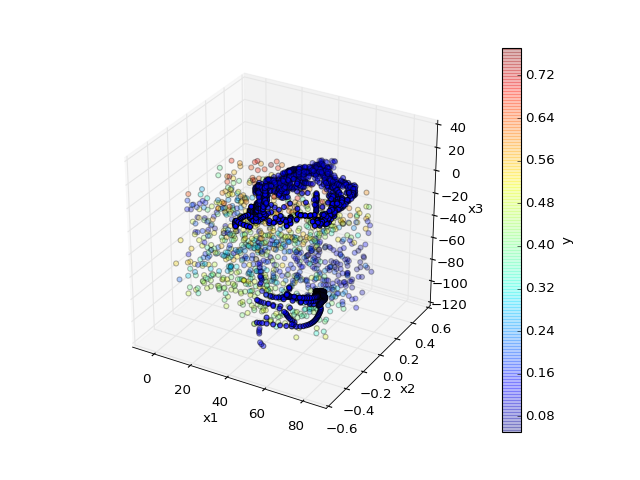

In [9]:
#fig, figStuff = graph_highD.graph3x1y(rand_x, rand_y, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

#pv
fig, figStuff = graph_highD.graph3x1y(rand_x, rand_pv_v, xCols=xCols, fig=None,
                      sbpltLoc=111, numPoints=numPoints*2, alpha=0.3)

figStuff[1].scatter(
                    xs = explorerBest[:,xCols[0]],
                    ys = explorerBest[:,xCols[1]],
                    zs = explorerBest[:,xCols[2]],
                    )
explorerID = 5
#figStuff[1].plot(
#                    xs = explorerSeries[:,explorerID,xCols[0]],
#                    ys = explorerSeries[:,explorerID,xCols[1]],
#                    zs = explorerSeries[:,explorerID,xCols[2]])

#------
#fig, figStuff = graph_highD.graph3x1y(rand_x, rand_pv_c, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2, alpha=0.3)

(1898, 10, 4)
(1898, 10, 4)
(1898, 10)
(1898,)
(1898,)


<IPython.core.display.Javascript object>


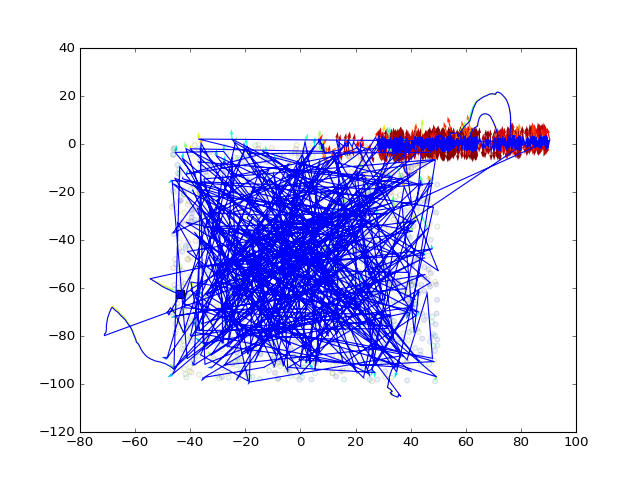

In [10]:
#explorerSeries.shape = (s, e, x)
#explorerVals.shape = (s, e)
print explorerGradients.shape
print explorerSeries.shape
print explorerVals.shape

print explorerSeries[:,explorerID,0].shape
print explorerVals[:,explorerID].shape

plt.figure()
plt.quiver(explorerSeries[:,explorerID,0], explorerSeries[:,explorerID,-1],
           explorerGradients[:,explorerID,0], explorerGradients[:,explorerID,-1],
           explorerVals[:,explorerID]
          )
plt.plot(explorerSeries[:,explorerID,0], explorerSeries[:,explorerID,-1])
#start point
plt.scatter(explorerSeries[0,explorerID,0], explorerSeries[0,explorerID,-1], marker='s', s=50)


#flattened point value graph over the features
plt.scatter(rand_x[:,0], rand_x[:,-1], c=rand_pv_v, alpha=0.1)

In [11]:
print pv_tests[3]

[[ 0.03472567 -0.59002799  0.2415272   0.76315099 -0.06054384 -0.03825464
   0.60514128  0.0772128   0.67331862 -0.17073655 -0.16762501  0.43436798
  -0.44970205 -0.11644335 -0.2178617  -0.57045913 -0.60891616 -0.69493735
   0.24698049 -0.42781344]
 [-0.09044082 -0.8025887   0.35347578 -0.20346589 -0.52724797  0.15007891
  -0.42247009 -0.20507686  0.33083275  0.01405115  0.7963689   0.2941128
   0.0852577  -0.64560616 -0.28058204 -0.3569029  -0.05915012  0.39990377
  -0.42175189  0.88847762]
 [-0.02986239 -0.63901502 -0.41610706 -0.53267264  0.49022803  0.9845733
   0.35383683 -0.01349878  1.39933598  0.34138352  1.09447682 -0.34416571
  -0.46869537 -0.57077402  0.44564837 -0.17639188 -0.01057964  0.33400175
  -0.06659765 -0.39723232]
 [ 0.01804359 -0.2188184  -0.23772356  0.19747129  0.79574835 -0.97816056
  -0.26397079 -0.25700793  1.54185665 -0.80714643  0.26217517 -0.05304707
  -0.01108136  0.88380927  0.07486678  0.9653284   0.1159285   0.25178498
   0.07760728  0.3935838 ]]


In [12]:
print y

[[-0.51967186]
 [-0.55173355]
 [-0.5809145 ]
 ..., 
 [-0.03711815]
 [-0.03817697]
 [-0.038853  ]]


In [13]:
evalStr = [
    'calc_agg_grad_w1',
    'calc_agg_grad_b1',
    'calc_agg_grad_w2',
    'calc_agg_grad_b2',
    'calc_agg_grad_w3',
    'calc_agg_grad_b3',

    'v',
    'm',
    'u',
    
    'w1',
    'w2',
    'w3',
    'b1',
    'b2',
    'b3'
    ]
d = main.space.expModel.get_evals(evalStr)

print d['w1']
print d['b2']

[[ 0.12065234 -0.58494157  0.07743675  0.07821637  0.30415702  0.39535484
  -0.27033961  0.40059403  0.38001677 -0.30600902  0.57045877  0.68061161
   0.51172405 -0.27067009  0.46526426  0.20533496 -0.28745267  0.27962309
  -0.02206206 -0.53504419]
 [ 0.70921588 -0.05524807  0.00344582 -0.01964604  0.31261277  0.8212558
   0.26496238 -0.19633025 -0.94182879 -0.20459968  0.40046224 -0.40749386
  -0.25099924 -0.40976581 -0.09098811 -0.68442243 -0.36232534  0.35540423
  -0.47810811 -0.59891218]
 [-0.37721729 -0.36877689 -0.13600674  0.29595071 -0.42740959 -0.25555331
   0.53784114 -0.09864297 -0.74225509  0.16221298 -0.13247748  0.09628205
  -0.02755239  0.0193494  -0.38939759  0.37166038  0.70308596  0.15789317
  -0.04425653  0.36770603]
 [-0.26735416 -0.19145256  0.04606662  0.03462767  0.74470729  0.06113563
  -0.11596519  0.25591445  0.71455067  0.3522009  -0.42954555 -0.21067032
  -0.40072414  0.24965701  0.68905783 -0.25909474 -0.10021562  0.1596299
  -0.14146605  0.45962355]]
[ 0.4

In [14]:
np.ones((5,3,2)).shape[1:]

(3, 2)

In [15]:
x = main.space.expHQ.test_actuals['isolationGrad']
print x

[[ 0.00372907  0.          0.         -0.82822418]
 [-0.72458923  0.          0.         -0.04023281]
 [-0.00163875  0.          0.          0.74426937]
 [-1.13281512  0.          0.         -0.49578872]
 [-0.00610022  0.          0.          0.14516269]
 [ 0.34775805  0.          0.          0.00171759]
 [ 1.11512804  0.          0.         -0.59635013]
 [-0.07587624  0.          0.          0.84268337]
 [ 0.24351096  0.          0.          0.16252047]
 [ 0.23089352  0.          0.          0.06424241]]
